In [30]:
import numpy as np
import numpy.random as r
import pandas as pd
import copy
import matplotlib.pyplot as plt
import time
import seaborn as sns
from collections import Counter
from IPython.display import display, clear_output

In [31]:
def is_winner(player):
    """
    Checks if player has won
    """
    win_set = [{0,1,2},{3,4,5},{6,7,8},{0,4,8},{0,3,6},{1,4,7},{2,4,6},{2,5,8}]
    for a in win_set:
        if player.issuperset(a):
            return a
    else:
        return False
    
def is_entry(cb,md):
    """
    Load entry from move dictionary else create one
    """
    # is there an entry?
    if cb in md: 
        prob = md[cb]
    else: # if no
        #create a new entry
        num_empty = cb.count('E')
        #count number of E's in current position
        cell_p = 1/num_empty
        prob = np.array([cell_p if cb[i]=='E' else 0 for i in range(9) ])
        md[cb] = prob
    return (prob,md)

def make_move(prob_dist):
    """
    Makes a move based on the probability distribution
    """
    play = r.rand(1)
    cprob = 0
    for i in range(9):
        cprob += prob_dist[i]
        if play < cprob:
            return i
    return 8

def findi(s, ch):
    """
    finds all indicies of chr in string s
    """
    return [i for i, ltr in enumerate(s) if ltr == ch]

def play_token(current_board,i,player_no=1):
    """
    Update gameboard based on current play
    """
    #update gameboard
    if player_no == 1:
        cboard = current_board[:i] + 'X' + current_board[(i+1):]
    else:    
        cboard = current_board[:i] + 'O' + current_board[(i+1):]
    return cboard

def update_dict(mdict,pmoves,weight = 1):
    """
    updates the move_dict based on the players moves (that led to a win)
    """
    
    learning_rate = 0.005*weight
    
    for board,cell in pmoves.items():
        #get current prob
        p = mdict[board]
        #improve cell
        p[cell] += learning_rate
        mdict[board] = p/p.sum()
    return mdict
        

def show_game(board,fig,ax):
    """
    Plots the board, returns boolean when game ends
    """
    over = False

    #set up the plot space
    ax.set_xlim(0.5,3.5)
    ax.set_ylim(0.5,3.5)
    ax.axhline(1.5,color='grey')
    ax.axhline(2.5,color='grey')
    ax.axvline(1.5,color='grey')
    ax.axvline(2.5,color='grey')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    

    
    play_x = set(findi(board,'X'))
    play_o = set(findi(board,'O'))
    cel_coord = {0:(1,3),1:(2,3),2:(3,3),3:(1,2),4:(2,2),5:(3,2),6:(1,1),7:(2,1),8:(3,1)}
    for i in play_x:
        ax.plot(cel_coord[i][0],cel_coord[i][1],'kX',markersize=52)
        
        #check if winner yet
        if is_winner(play_x):
            winning_set = is_winner(play_x)
            pnt1 = -1
            pnt2 = -1
            for pnt in winning_set:
                if (pnt1==-1)&(pnt2==-1):
                    pnt1 = pnt
                else:
                    pnt2 = copy.deepcopy(pnt1)
                    pnt1 = pnt
                    ax.plot([cel_coord[pnt1][0],cel_coord[pnt2][0]],[cel_coord[pnt1][1],cel_coord[pnt2][1]],'g-',\
                            linewidth=4)
            over = True
    for i in play_o:
        ax.plot(cel_coord[i][0],cel_coord[i][1],'ro',markeredgewidth=20,markerfacecolor='w',markersize=52)
        
        #check if winner yet
        if is_winner(play_o):
            winning_set = is_winner(play_o)
            pnt1 = -1
            pnt2 = -1
            for pnt in winning_set:
                if (pnt1==-1)&(pnt2==-1):
                    pnt1 = pnt
                else:
                    pnt2 = copy.deepcopy(pnt1)
                    pnt1 = pnt
                    ax.plot([cel_coord[pnt1][0],cel_coord[pnt2][0]],[cel_coord[pnt1][1],cel_coord[pnt2][1]],'g-',\
                            linewidth=4)
            over = True
    display(fig)
    clear_output(wait = True)
    return over

In [27]:
max_ind = {}
win_log = []

for trial in range(1):

    move_dict = {}

    # #set up the plot
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(111)

    #play n_games
    for n_games in range(100000):

        cboard = 'EEEEEEEEE' #initial board

        #set up the player_moves
        ply1_moves = {}
        ply2_moves = {}

        for move in range(9):
            if (move%2) == 0:
                player = 1
            else:
                player = 2

            #load probability
            (prob,move_dict) = is_entry(cboard,move_dict)
            #make a selection
            i = make_move(prob)

            #save selection
            if player==1:
                ply1_moves[cboard] = i
            else:
                ply2_moves[cboard] = i  
            #make move
            cboard = play_token(cboard,i,player)
            #check if there's a winner
            if is_winner(set(findi(cboard,'X'))):
                break
            if is_winner(set(findi(cboard,'O'))):
                break 
    #         if show_game(cboard,fig,ax):
    #             break
    #         time.sleep(.1)

        #was there a winner?
        if is_winner(set(findi(cboard,'X'))):
            #player 1 wins
            #print('Player 1 Wins game %d'%n_games)
            move_dict = update_dict(move_dict,ply1_moves)
            win_log.append('X')
        elif is_winner(set(findi(cboard,'O'))):
            #player 2 wins
            #print('Player 2 Wins game %d'%n_games)
            move_dict = update_dict(move_dict,ply2_moves)
            win_log.append('O')
        else:
            #ties are better than a lose
            move_dict = update_dict(move_dict,ply1_moves,.5)
            move_dict = update_dict(move_dict,ply2_moves,.5)
            win_log.append('T')
    #     else:
    #         print('Tie')
    
#     mind = move_dict['EEEEEEEEE'].argmax()
#     if mind in {0,2,6,8}:
#         max_ind['corner'] = max_ind.get('corner',0) + 1
#     elif mind in {1,3,5,7}:
#         max_ind['side'] = max_ind.get('side',0) + 1 
#     elif mind in {4}:
#         max_ind['center'] = max_ind.get('center',0) + 1
print('Complete')


Complete


In [28]:
cnts = [Counter(win_log[(1000*r):(1000*(r+1))])for r in range(0,100)]

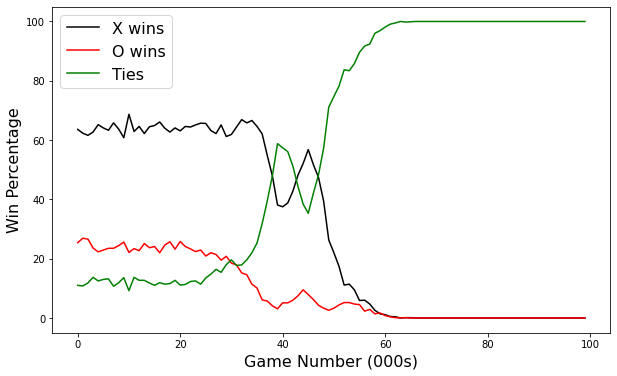

In [29]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.array([cnts[i]['X'] for i in range(len(cnts))])/10,'k-',label="X wins")
plt.plot(np.array([cnts[i]['O'] for i in range(len(cnts))])/10,'r-',label="O wins")
plt.plot(np.array([cnts[i]['T'] for i in range(len(cnts))])/10,'g-',label="Ties")
plt.xlabel('Game Number (000s)',fontsize=16)
plt.ylabel('Win Percentage',fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [6]:
move_dict['EEEEEEEEE'].reshape(3,-1)

array([[3.51236400e-198, 2.12015014e-191, 9.62157414e-172],
       [5.57881471e-194, 1.00000000e+000, 1.88182166e-202],
       [4.06584639e-194, 3.70232520e-191, 1.28065205e-185]])

In [10]:
move_dict['EEEEXEEEE'].reshape(3,-1)

array([[1.62779625e-156, 4.94041145e-165, 9.46370249e-157],
       [1.06823869e-170, 0.00000000e+000, 3.63826155e-170],
       [1.00000000e+000, 1.83846803e-171, 5.14380635e-161]])

In [11]:
move_dict['EEEEXEOEE'].reshape(3,-1)

array([[3.32250923e-156, 6.68496400e-165, 2.11223427e-167],
       [1.00000000e+000, 0.00000000e+000, 8.37447102e-167],
       [0.00000000e+000, 2.88973248e-142, 5.01502706e-158]])

In [12]:
move_dict['EEEXXEOEE'].reshape(3,-1)

array([[4.70312463e-157, 3.20277571e-157, 4.83558646e-159],
       [0.00000000e+000, 0.00000000e+000, 1.00000000e+000],
       [0.00000000e+000, 7.71270072e-157, 1.92274493e-156]])

In [13]:
move_dict['EEEXXOOEE'].

array([1.40609055e-158, 4.24361187e-152, 5.84094565e-152, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.79836875e-148,
       1.00000000e+000])

In [ ]:
move_dict['EEEXXOOXE']

False

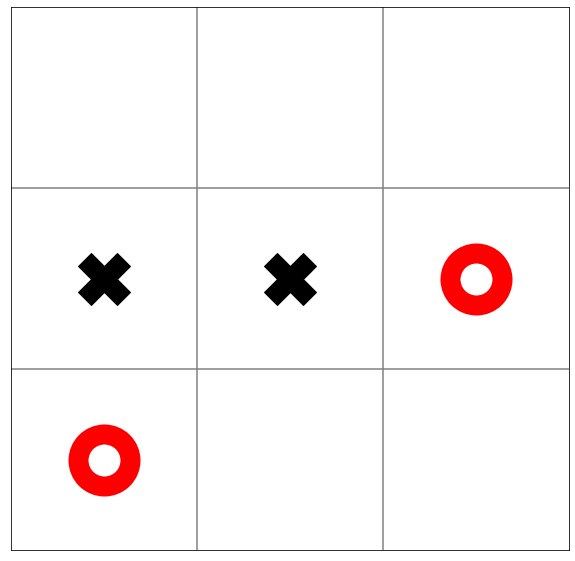

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
show_game('EEEXXOOEE',fig,fig.add_subplot(111))